In [18]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, cophenet, leaves_list
from scipy.spatial.distance import squareform

from mesmerize import Transmission
from mesmerize.analysis.math.emd import emd_1d
from sklearn.metrics import pairwise_distances
import pandas as pd

In [2]:
t = Transmission.from_hdf5('/home/kushal/Sars_stuff/hier_all_promoters.ptrn')

t.df.columns

X = np.vstack(t.df._SPLICE_ARRAYS.values)

X += np.abs(X.min())

In [3]:
X.shape

(258, 1000)

In [4]:
distM = pairwise_distances(X, metric=emd_1d, n_jobs=22)

np.save('/home/kushal/Sars_stuff/cell_types_dm_1000.npy', distM)

cnM = squareform(distM, checks=False)

In [27]:
DM_emd = np.load('/home/kushal/Sars_stuff/cell_types_distance_matrix_log_abs.npy')

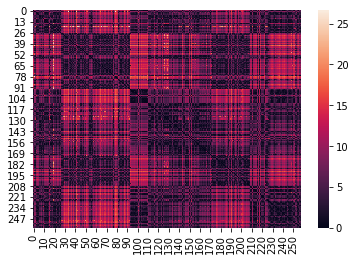

In [6]:
sns.heatmap(distM)

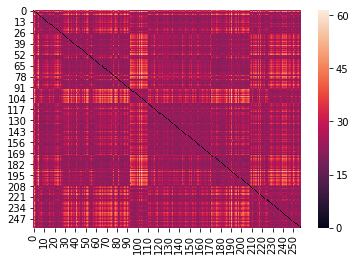

In [7]:
DM_euc = pairwise_distances(X)
sns.heatmap(DM_euc)

In [8]:
Z_emd = linkage(distM, method='complete', optimal_ordering=True)
Z_euc = linkage(DM_euc, method='complete', optimal_ordering=True)

/home/kushal/python-venvs/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


In [10]:
print(cophenet(Z_emd, squareform(distM, checks=False)))
print(cophenet(Z_euc, squareform(DM_euc, checks=False)))

(0.6687118158419584, array([188.259567  , 188.259567  ,  70.90899848, ..., 188.259567  ,
        70.90899848, 188.259567  ]))
(0.5546556301664136, array([306.03403511, 285.47503145, 285.47503145, ..., 186.18068704,
       186.18068704,  62.37114658]))


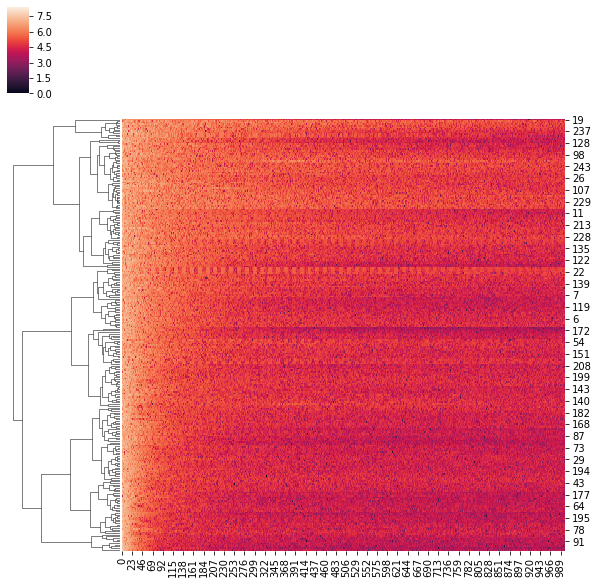

In [11]:
sns.clustermap(X, row_cluster=True, col_cluster=False, row_linkage=Z_emd)

In [19]:
def calc_agg_coeff(lkg) -> float:
    """Return the agglomerative coefficient.

    This measures the clustering structure of the linkage matrix. Because
    it grows with the number of observations, this measure should not be
    used to compare datasets of very different sizes.

    For each observation i, denote by m(i) its dissimilarity to the first
    cluster it is merged with, divided by the dissimilarity of the merger
    in the final step of the algorithm. The agglomerative coefficient is
    the average of all 1 - m(i).

    """
    # Turn into pandas DataFrame for fancy indexing
    Z = pd.DataFrame(lkg, columns=['obs1', 'obs2', 'dist', 'n_org'])
    
    leaves = leaves_list(lkg)

    # Get all distances at which an original observation is merged
    all_dist = Z[(Z.obs1.isin(leaves)) | (Z.obs2.isin(leaves))].dist.values

    # Divide all distances by last merger
    all_dist /= lkg[-1][2]

    # Calc final coefficient
    coeff = np.mean(1 - all_dist)

    return coeff

In [20]:
calc_agg_coeff(Z_emd)

0.9409203124505928

In [21]:
calc_agg_coeff(Z_euc)

0.8947060194627149

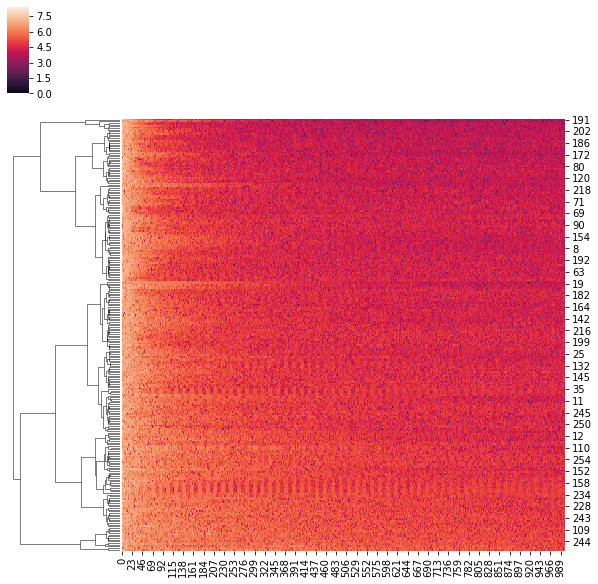

In [12]:
sns.clustermap(X, row_cluster=True, col_cluster=False, row_linkage=Z_euc)